In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
df = pd.read_csv('../../data/full_data/auto_dataset.csv')
y_data = np.load('../../data/full_data/y_data.npy')

In [3]:
le = LabelEncoder()
y_data = le.fit_transform(y_data)
y_data

array([1, 2, 2, 1, 0, 2, 0, 2, 2, 1, 2, 1, 2, 1, 0, 0, 2, 1, 1, 2, 0, 1,
       1, 2, 2, 2, 0, 0, 0, 2, 1, 2, 0, 1, 2, 1, 1, 0, 2, 1, 0, 2, 2, 0,
       1, 0, 0, 1, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 2, 2, 0, 1, 0, 0, 0,
       1, 0, 2, 1, 2, 1, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 2, 2, 1, 2, 0, 1, 1, 1, 1, 2, 0, 1, 2, 1, 2, 0, 1, 2, 1,
       0, 2, 1, 2, 1, 1, 0, 2, 2, 1, 1, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 1,
       0, 1, 2, 1, 0, 0, 1, 0, 0, 2, 0, 2, 2, 1, 2, 1, 2, 1, 1, 2])

In [4]:
X_trainval, X_test, y_trainval, y_test = train_test_split(df, y_data, test_size=0.2, stratify=y_data, random_state=2)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=2)

In [5]:
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_val = std.transform(X_val)
X_test = std.transform(X_test)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [6]:
class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]
    
    def __len__(self):
        return len(self.X_data)

train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [7]:
target_list = []

for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

In [8]:
def get_class_distribution(obj):
    count_dict = {
        'rating_1': 0,
        'rating_2': 0,
        'rating_3': 0,
    }
    
    for i in obj:
        if i == 0:
            count_dict['rating_1'] += 1
        elif i == 1:
            count_dict['rating_2'] += 1
        elif i == 2:
            count_dict['rating_3'] += 1
        else:
            print('Check classes')
            
    return count_dict

In [9]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float)

print(class_weights)

tensor([0.0270, 0.0294, 0.0270])


In [10]:
class_weights_all = class_weights[target_list]

In [11]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [21]:
EPOCHS = 10000
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
LEARNING_RATE = 1e-5
NUM_FEATURES = len(df.columns)
NUM_CLASSES = 3

In [13]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler)

val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [22]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [23]:
device = 'cpu'
# device = torch.device('cuda:1')

In [16]:
writer = SummaryWriter('../../torchlogs/')

2023-01-19 12:44:57.570980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 12:44:58.131799: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-19 12:44:58.131853: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-19 12:44:58.131859: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [24]:
model = MulticlassClassification(num_feature=NUM_FEATURES, num_class=NUM_CLASSES)
writer.add_graph(model, next(iter(train_loader))[0])
model.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=1536, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [25]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [26]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [27]:
print('Begin training.')
num_epochs = 0
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    num_epochs+=1

    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        writer.add_scalar('Loss/Epochs', train_loss, num_epochs)
        writer.add_scalar('Accuracy/Epochs', train_acc, num_epochs)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    with torch.no_grad():
        val_epochs_loss = 0
        val_epochs_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epochs_loss += val_loss.item()
            val_epochs_acc += val_acc.item()
    
    loss_stats['train'].append(train_epoch_loss/ len(train_loader))
    loss_stats['val'].append(val_epochs_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epochs_acc/len(val_loader))
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epochs_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epochs_acc/len(val_loader):.3f}')

writer.flush()
writer.close()

Begin training.


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.16320 | Val Loss: 1.09498 | Train Acc: 32.429 | Val Acc: 30.769
Epoch 002: | Train Loss: 1.14312 | Val Loss: 1.08427 | Train Acc: 36.143 | Val Acc: 53.846
Epoch 003: | Train Loss: 1.12154 | Val Loss: 1.07535 | Train Acc: 38.429 | Val Acc: 53.846
Epoch 004: | Train Loss: 1.06674 | Val Loss: 1.07701 | Train Acc: 48.000 | Val Acc: 46.154
Epoch 005: | Train Loss: 1.00245 | Val Loss: 1.08462 | Train Acc: 49.143 | Val Acc: 30.769
Epoch 006: | Train Loss: 1.07954 | Val Loss: 1.10573 | Train Acc: 39.143 | Val Acc: 38.462
Epoch 007: | Train Loss: 1.02930 | Val Loss: 1.12719 | Train Acc: 48.286 | Val Acc: 30.769
Epoch 008: | Train Loss: 1.06392 | Val Loss: 1.16123 | Train Acc: 41.857 | Val Acc: 30.769
Epoch 009: | Train Loss: 0.99540 | Val Loss: 1.17260 | Train Acc: 47.429 | Val Acc: 38.462
Epoch 010: | Train Loss: 1.05818 | Val Loss: 1.18345 | Train Acc: 46.286 | Val Acc: 38.462
Epoch 011: | Train Loss: 0.97075 | Val Loss: 1.18833 | Train Acc: 54.143 | Val Acc: 38.462

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

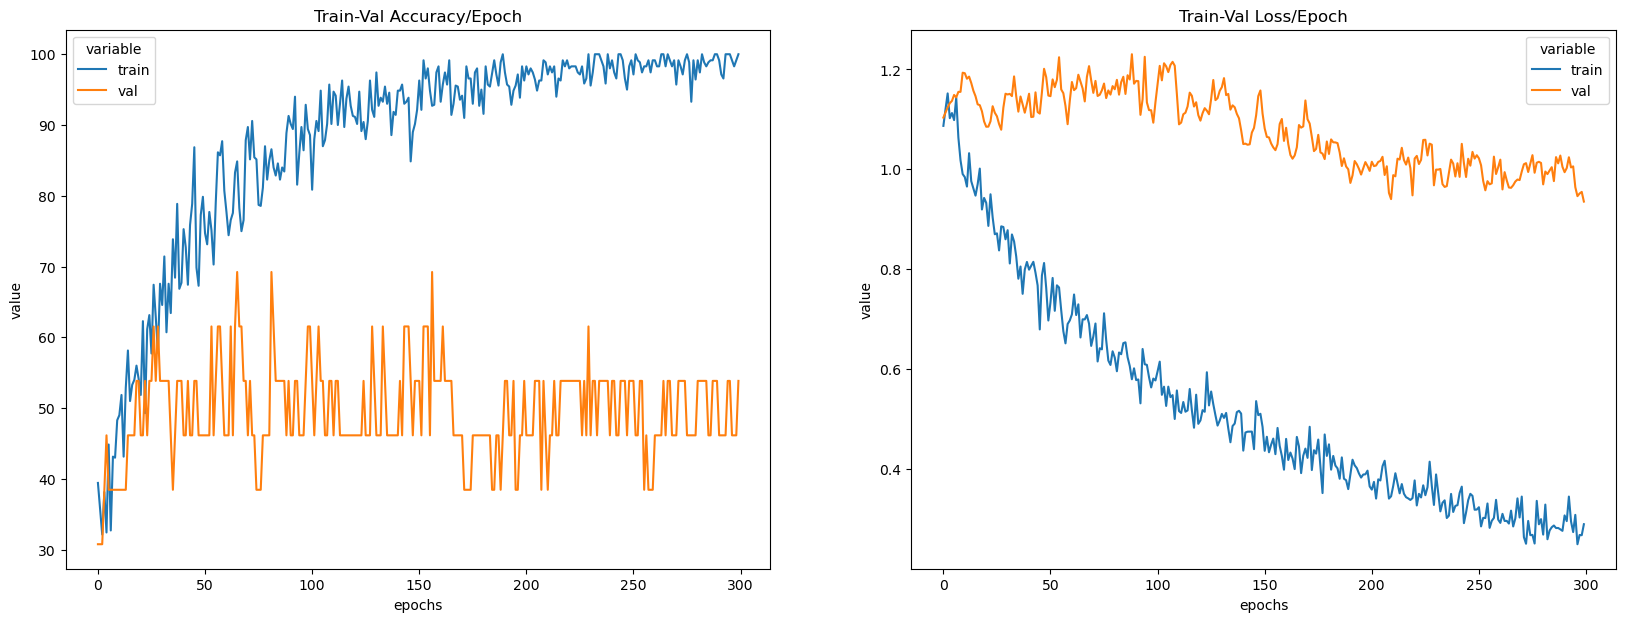

In [29]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={'index':'epochs'})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={'index':'epochs'})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

sns.lineplot(data=train_val_acc_df, x='epochs', y='value', hue='variable', ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x='epochs', y='value', hue='variable', ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [36]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim=1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<AxesSubplot: >

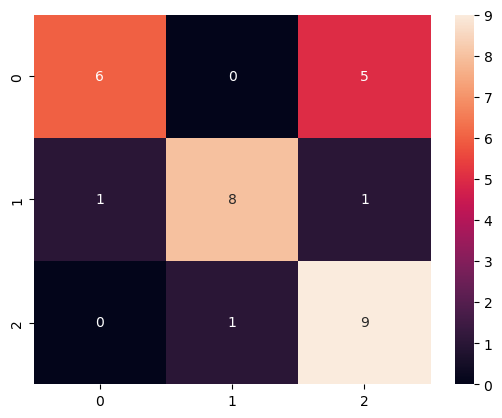

In [37]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

sns.heatmap(confusion_matrix_df, annot=True)

In [38]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.89      0.80      0.84        10
           2       0.60      0.90      0.72        10

    accuracy                           0.74        31
   macro avg       0.78      0.75      0.74        31
weighted avg       0.78      0.74      0.74        31

